# Plant Leaf Disease Classification (Basic) — Ultralytics YOLOv8 (Classify)

**Goal:** Binary classification **healthy vs sick**  
**Image size:** `224x224`  
**Dataset structure (required):**
```
dataset_plants_final/
  train/healthy, train/sick
  val/healthy,   val/sick
  test/healthy,  test/sick
  unlabeled/images   (not used in basic)
```

This notebook follows a CLI-first Ultralytics style (similar to YOLO notebooks) and then computes
**Accuracy, Precision, Recall, F1** on the fixed **test** split using `scikit-learn`.


## 0) (Optional) GPU check

In [1]:
!nvidia-smi

Tue Jan 27 12:14:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.74                 Driver Version: 591.74         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   52C    P8              5W /   95W |     996MiB /   8188MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1) Install dependencies

If you already have the packages installed, this cell is safe to skip.


In [2]:
!pip -q install ultralytics opencv-python matplotlib scikit-learn pandas numpy tqdm pillow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.10.0+cpu requires torch==2.10.0, but you have torch 2.9.1 which is incompatible.


## 2) Imports & utilities

In [3]:
from pathlib import Path
import json
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Nazar\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 3) Locate dataset folder automatically

We search for a folder named `dataset_plants_final` in common locations:
- `/content`
- `/content/drive/MyDrive` (Colab + Drive)
- current working directory (local)


In [ ]:
TARGET = "dataset_plants_final"

def find_dataset_dir():
    candidates = []
    for root in [Path("/content"), Path("/content/drive/MyDrive"), Path(".")]:
        if root.exists():
            candidates += [p for p in root.rglob(TARGET) if p.is_dir()]
    # deduplicate while preserving order 
    for c in candidates:
        if c not in uniq:
            uniq.append(c)
    return uniq

matches = find_dataset_dir()
print("Found dataset candidates:")
for i, p in enumerate(matches):
    print(f"[{i}] {p.resolve()}")

assert len(matches) > 0, "dataset_plants_final not found. Upload/unzip it or mount Drive."
DATA_DIR = matches[0]
DATA_DIR


Found dataset candidates:
[0] D:\Repos\ml_week\dataset_plants_final


WindowsPath('dataset_plants_final')

## 4) Sanity-check required subfolders

In [5]:
def assert_dir(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p.resolve()}")

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"
UNLAB_DIR = DATA_DIR / "unlabeled" / "images"

for p in [
    TRAIN_DIR/"healthy", TRAIN_DIR/"sick",
    VAL_DIR/"healthy",   VAL_DIR/"sick",
    TEST_DIR/"healthy",  TEST_DIR/"sick",
]:
    assert_dir(p)

print("✅ train/val/test structure OK")
print("DATA_DIR:", DATA_DIR.resolve())


✅ train/val/test structure OK
DATA_DIR: D:\Repos\ml_week\dataset_plants_final


## 5) Quick EDA: counts + sample images

In [6]:
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}

def count_images(folder: Path) -> int:
    return sum(1 for p in folder.rglob("*") if p.suffix.lower() in IMG_EXTS)

rows = []
for split_name, split_dir in [("train", TRAIN_DIR), ("val", VAL_DIR), ("test", TEST_DIR)]:
    for cls in ["healthy", "sick"]:
        rows.append({"split": split_name, "class": cls, "count": count_images(split_dir/cls)})

rows.append({"split": "unlabeled", "class": "images", "count": count_images(UNLAB_DIR) if UNLAB_DIR.exists() else 0})

df_counts = pd.DataFrame(rows)
df_counts


split    class  count
0      train  healthy    169
1      train     sick    431
2        val  healthy     58
3        val     sick    142
4       test  healthy     54
5       test     sick    146
6  unlabeled   images   5000

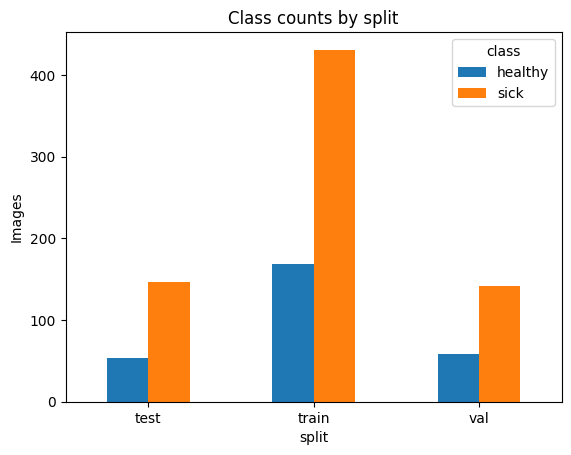

class  healthy  sick
split               
test        54   146
train      169   431
val         58   142

In [7]:
pivot = df_counts[df_counts["split"].isin(["train","val","test"])].pivot(index="split", columns="class", values="count").fillna(0).astype(int)
pivot.plot(kind="bar")
plt.title("Class counts by split")
plt.ylabel("Images")
plt.xticks(rotation=0)
plt.show()

pivot


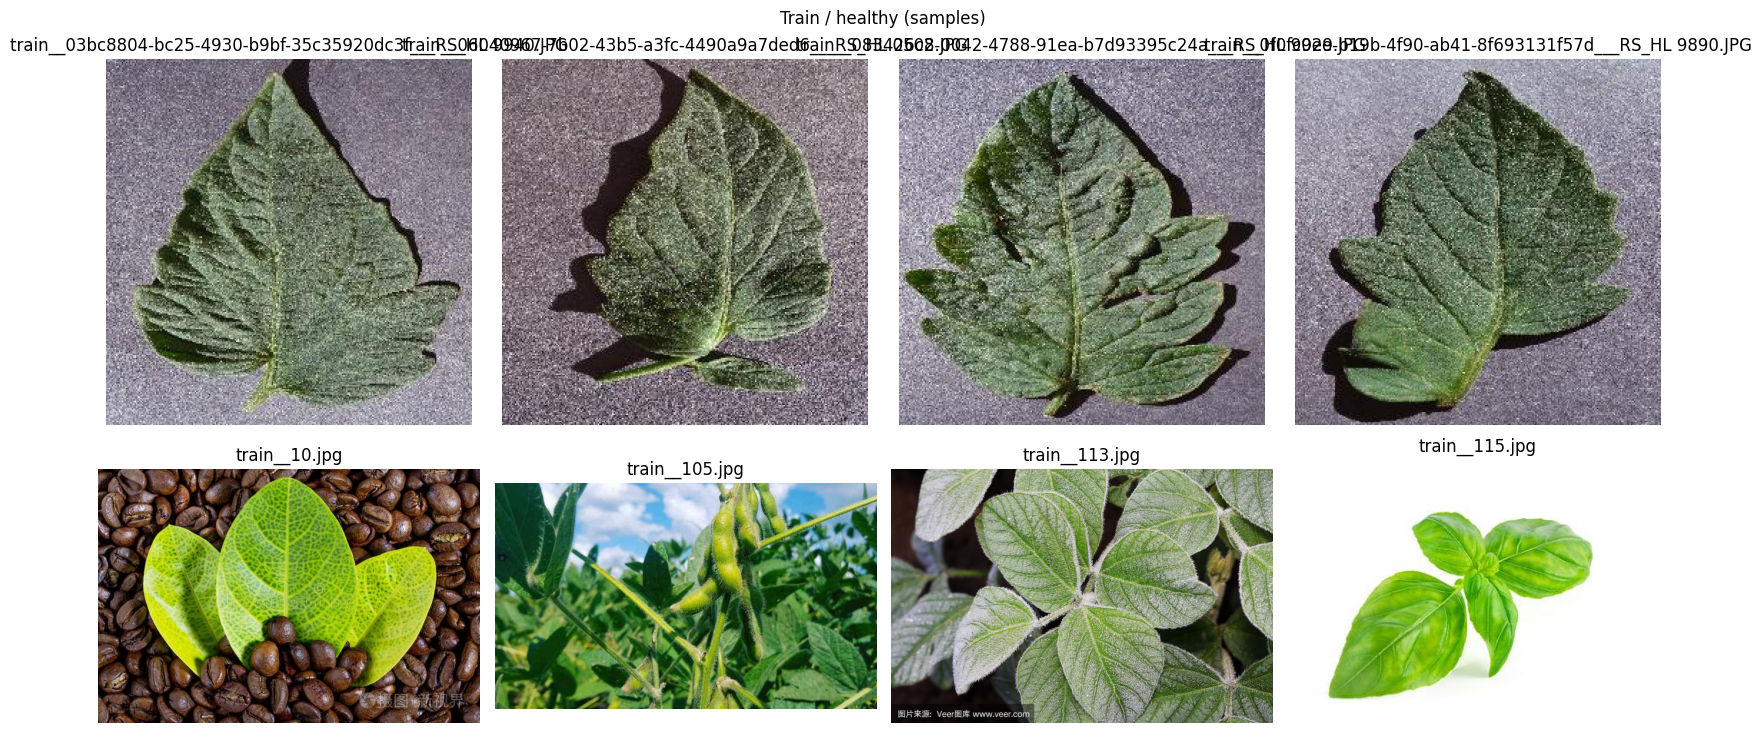

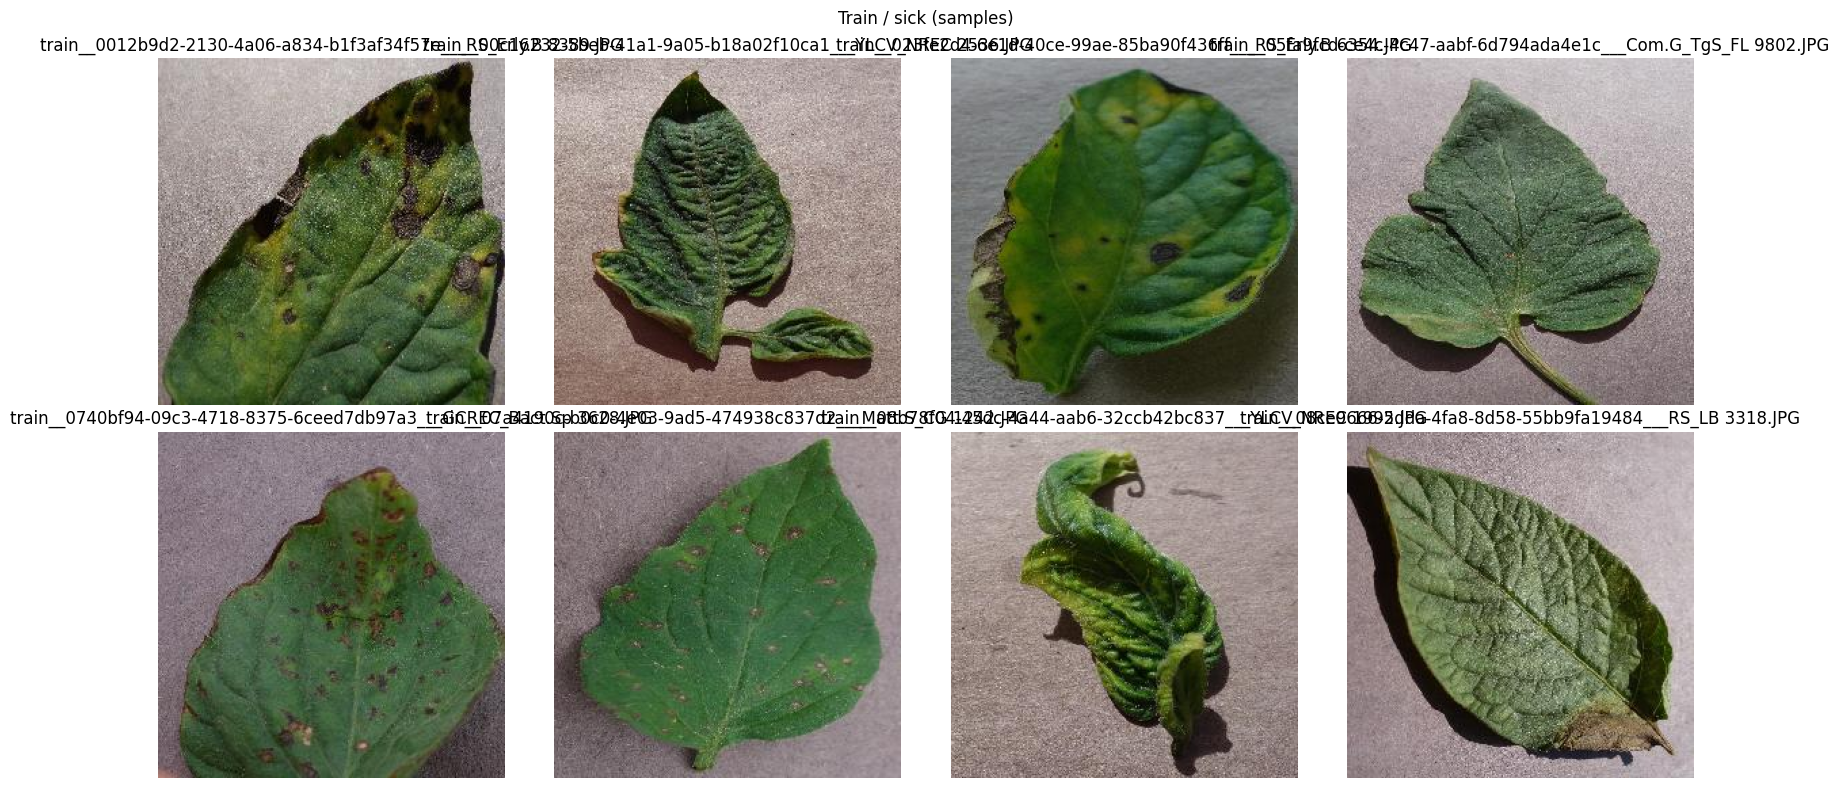

In [8]:
def show_samples(folder: Path, n=8, title=""):
    paths = [p for p in folder.rglob("*") if p.suffix.lower() in IMG_EXTS]
    paths = paths[:n]
    cols = min(4, len(paths))
    rows = int(np.ceil(len(paths)/cols)) if cols else 1
    plt.figure(figsize=(4*cols, 4*rows))
    for i, p in enumerate(paths, start=1):
        img = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.name)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(TRAIN_DIR/"healthy", n=8, title="Train / healthy (samples)")
show_samples(TRAIN_DIR/"sick", n=8, title="Train / sick (samples)")


## 6) Train baseline classifier (Ultralytics CLI)

We use a lightweight model: `yolov8n-cls.pt`  
Key settings:
- `imgsz=224`
- `epochs`, `batch` adjustable
- `name=baseline_cls` so outputs go to `runs/classify/baseline_cls`


In [9]:
SEED = 42
EPOCHS = 10
BATCH  = 32
IMGSZ  = 224

# Train
!yolo task=classify mode=train model=yolov8n-cls.pt data="{DATA_DIR}" imgsz={IMGSZ} epochs={EPOCHS} batch={BATCH} seed={SEED} name=baseline_cls



Ultralytics 8.4.7  Python-3.13.7 torch-2.9.1+cpu CPU (AMD Ryzen 7 7435HS)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_plants_final, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=baseline_cls, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

## 7) Visualize training curves (results.png)

Run dir: D:\Repos\ml_week\runs\classify\baseline_cls
results.png exists: True


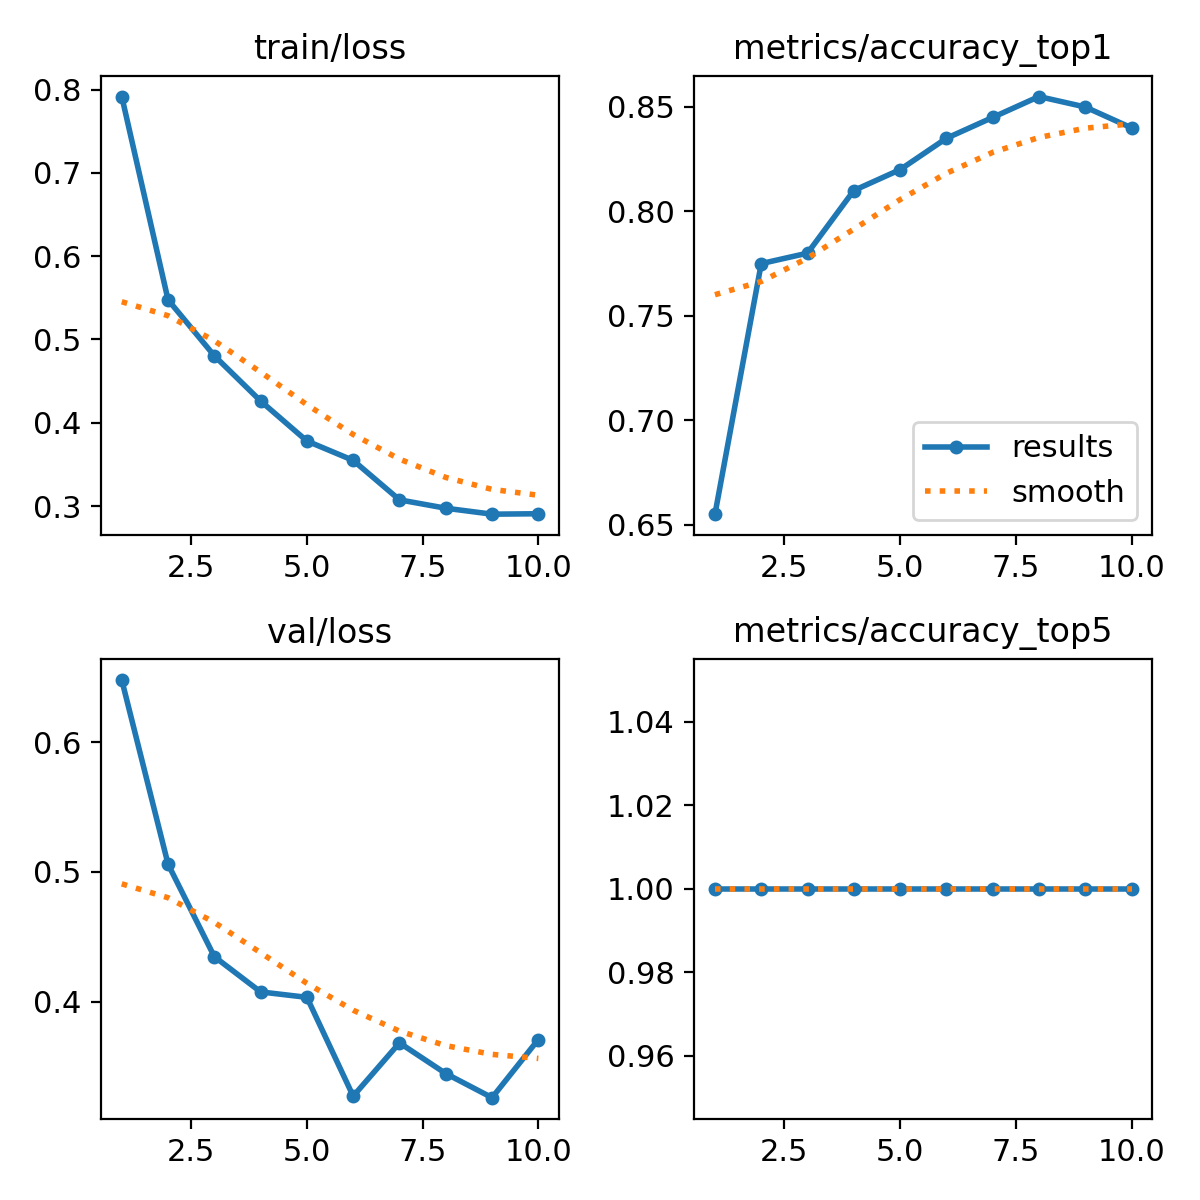

In [10]:
from IPython.display import Image as IPyImage, display

run_dir = Path("runs/classify/baseline_cls")
img_path = run_dir / "results.png"

print("Run dir:", run_dir.resolve())
print("results.png exists:", img_path.exists())

if img_path.exists():
    display(IPyImage(filename=str(img_path), width=900))


## 8) Validate on val and test splits

- `split=val` for tuning/monitoring
- `split=test` for final evaluation


In [11]:
best_pt = Path("runs/classify/baseline_cls/weights/best.pt")
assert best_pt.exists(), f"best.pt not found: {best_pt.resolve()}"
best_pt


WindowsPath('runs/classify/baseline_cls/weights/best.pt')

In [12]:
!yolo task=classify mode=val model="{best_pt}" data="{DATA_DIR}" imgsz={IMGSZ} split=val

Ultralytics 8.4.7  Python-3.13.7 torch-2.9.1+cpu CPU (AMD Ryzen 7 7435HS)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: D:\Repos\ml_week\dataset_plants_final\train... found 600 images in 2 classes  
val: D:\Repos\ml_week\dataset_plants_final\val... found 200 images in 2 classes  
test: D:\Repos\ml_week\dataset_plants_final\test... found 200 images in 2 classes  
val: Fast image access  (ping: 0.00.0 ms, read: 250.188.9 MB/s, size: 71.5 KB)

val: Scanning D:\Repos\ml_week\dataset_plants_final\val... 200 images, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 23.3Mit/s 0.0s

               classes   top1_acc   top5_acc: 8% ╸─────────── 1/13 1.2it/s 0.2s<9.7s
               classes   top1_acc   top5_acc: 15% ━╸────────── 2/13 1.8it/s 0.6s<6.2s
               classes   top1_acc   top5_acc: 23% ━━╸───────── 3/13 1.9it/s 1.0s<5.1s
               classes   top1_acc   top5_acc: 31% ━━━╸──────── 4/13 2.2it/s 1.3s<4.0s
               classes   top1_acc   top5_

In [13]:
!yolo task=classify mode=val model="{best_pt}" data="{DATA_DIR}" imgsz={IMGSZ} split=test

Ultralytics 8.4.7  Python-3.13.7 torch-2.9.1+cpu CPU (AMD Ryzen 7 7435HS)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: D:\Repos\ml_week\dataset_plants_final\train... found 600 images in 2 classes  
val: D:\Repos\ml_week\dataset_plants_final\val... found 200 images in 2 classes  
test: D:\Repos\ml_week\dataset_plants_final\test... found 200 images in 2 classes  
test: Fast image access  (ping: 0.20.2 ms, read: 6.26.1 MB/s, size: 82.0 KB)

test: Scanning D:\Repos\ml_week\dataset_plants_final\test... 41 images, 0 corrupt: 20% ━━────────── 41/200 121.3it/s 0.1s<1.3s
test: Scanning D:\Repos\ml_week\dataset_plants_final\test... 105 images, 0 corrupt: 52% ━━━━━━────── 105/200 259.0it/s 0.2s<0.4s
test: Scanning D:\Repos\ml_week\dataset_plants_final\test... 164 images, 0 corrupt: 82% ━━━━━━━━━╸── 164/200 358.3it/s 0.3s<0.1s
test: Scanning D:\Repos\ml_week\dataset_plants_final\test... 200 images, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 538.0it/s 0.4s


## 9) Compute required metrics on TEST (Accuracy / Precision / Recall / F1)

Ultralytics provides accuracy, but the project requires:
- Accuracy
- Precision
- Recall
- F1-score

We compute these with `scikit-learn` using predictions on the fixed `test` split.

We define **positive class = sick (1)**, **healthy = 0**.


In [14]:
# Collect test image paths + y_true (healthy=0, sick=1)
test_paths = []
y_true = []

for cls_name, label in [("healthy", 0), ("sick", 1)]:
    for p in (TEST_DIR/cls_name).rglob("*"):
        if p.suffix.lower() in IMG_EXTS:
            test_paths.append(str(p))
            y_true.append(label)

y_true = np.array(y_true, dtype=int)
print("Test images:", len(test_paths), "| sick positives:", int(y_true.sum()))

# Load model in Python
model = YOLO(str(best_pt))

# Determine index of 'sick' in model.names
names = model.names if isinstance(model.names, dict) else {i:n for i,n in enumerate(model.names)}
inv_names = {v:k for k,v in names.items()}
assert "sick" in inv_names and "healthy" in inv_names, f"Unexpected model.names: {names}"
SICK_IDX = inv_names["sick"]
print("Model names:", names, "| SICK_IDX:", SICK_IDX)


Test images: 200 | sick positives: 146
Model names: {0: 'healthy', 1: 'sick'} | SICK_IDX: 1


In [15]:
# Predict (per-image, stable and simple)
y_pred = []
p_sick = []

for path in test_paths:
    r = model.predict(source=path, imgsz=IMGSZ, verbose=False)[0]
    prob_vec = r.probs.data.detach().cpu().numpy()
    p = float(prob_vec[SICK_IDX])
    pred = 1 if int(np.argmax(prob_vec)) == SICK_IDX else 0
    y_pred.append(pred)
    p_sick.append(p)

y_pred = np.array(y_pred, dtype=int)
p_sick = np.array(p_sick, dtype=float)

metrics = {
    "accuracy": float(accuracy_score(y_true, y_pred)),
    "precision": float(precision_score(y_true, y_pred, zero_division=0)),
    "recall": float(recall_score(y_true, y_pred, zero_division=0)),
    "f1": float(f1_score(y_true, y_pred, zero_division=0)),
}
metrics


{'accuracy': 0.885,
 'precision': 0.9555555555555556,
 'recall': 0.8835616438356164,
 'f1': 0.9181494661921709}

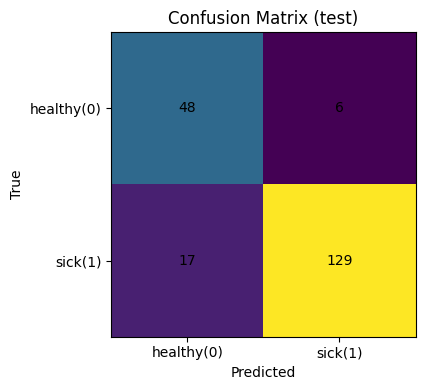

✅ saved: D:\Repos\ml_week\results\confusion_matrix.png


In [16]:
# Confusion matrix + save artifact
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix (test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["healthy(0)", "sick(1)"])
plt.yticks([0,1], ["healthy(0)", "sick(1)"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)
cm_path = RESULTS_DIR / "confusion_matrix.png"
plt.savefig(cm_path, dpi=150)
plt.show()

print("✅ saved:", cm_path.resolve())


In [17]:
# Save metrics.json / metrics.csv (project requirement)
payload = {
    "model_version": "ultralytics_yolov8n_cls_baseline",
    "imgsz": IMGSZ,
    "epochs": EPOCHS,
    "batch": BATCH,
    "seed": SEED,
    "positive_class": "sick",
    **{f"test_{k}": v for k,v in metrics.items()},
}

json_path = RESULTS_DIR / "metrics.json"
csv_path  = RESULTS_DIR / "metrics.csv"

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pd.DataFrame([payload]).to_csv(csv_path, index=False)

print("✅ saved:", json_path.resolve())
print("✅ saved:", csv_path.resolve())
payload


✅ saved: D:\Repos\ml_week\results\metrics.json
✅ saved: D:\Repos\ml_week\results\metrics.csv


{'model_version': 'ultralytics_yolov8n_cls_baseline',
 'imgsz': 224,
 'epochs': 10,
 'batch': 32,
 'seed': 42,
 'positive_class': 'sick',
 'test_accuracy': 0.885,
 'test_precision': 0.9555555555555556,
 'test_recall': 0.8835616438356164,
 'test_f1': 0.9181494661921709}

## 10) Performance benchmarking (latency / throughput)

We measure inference speed on a subset of test images (default 100).
- batch=1  -> latency (ms/image)
- batch=32 -> throughput (img/s)

Then we append results into `results/metrics.json` and `results/metrics.csv`.


In [18]:
def benchmark_predict(paths, batch=1, warmup=5):
    # warmup
    for _ in range(warmup):
        _ = model.predict(source=paths[:batch], imgsz=IMGSZ, batch=batch, verbose=False)

    t0 = time.perf_counter()
    _ = model.predict(source=paths, imgsz=IMGSZ, batch=batch, verbose=False)
    t1 = time.perf_counter()

    total_time = t1 - t0
    total_images = len(paths)
    latency_ms = (total_time / max(total_images, 1)) * 1000
    throughput = total_images / max(total_time, 1e-9)
    return latency_ms, throughput, total_time

sample_paths = test_paths[:100] if len(test_paths) >= 100 else test_paths

lat1, thr1, t1 = benchmark_predict(sample_paths, batch=1)
lat32, thr32, t32 = benchmark_predict(sample_paths, batch=32)

print(f"batch=1:  latency={lat1:.2f} ms/img, throughput={thr1:.2f} img/s, total={t1:.2f}s")
print(f"batch=32: latency={lat32:.2f} ms/img, throughput={thr32:.2f} img/s, total={t32:.2f}s")

payload["latency_ms_per_image_batch1"] = float(lat1)
payload["throughput_img_s_batch32"] = float(thr32)

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pd.DataFrame([payload]).to_csv(csv_path, index=False)

print("✅ updated:", json_path.resolve())


batch=1:  latency=18.62 ms/img, throughput=53.70 img/s, total=1.86s
batch=32: latency=17.52 ms/img, throughput=57.08 img/s, total=1.75s
✅ updated: D:\Repos\ml_week\results\metrics.json


## 11) Notebook inference demo (single image)

Shows predicted class + confidence.


Image: dataset_plants_final\test\healthy\test__0414429e-4295-4216-b2ed-96b21cb35928___JR_HL 8250.JPG
Prediction: healthy | confidence: 0.8965


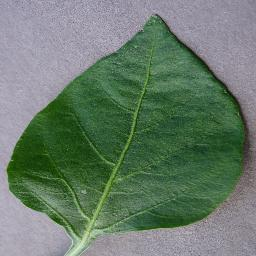

In [19]:
# Pick an example image (first test image)
one_path = Path(test_paths[0])
r = model.predict(source=str(one_path), imgsz=IMGSZ, verbose=False)[0]
prob_vec = r.probs.data.detach().cpu().numpy()

pred_idx = int(np.argmax(prob_vec))
pred_name = names[pred_idx]
conf = float(prob_vec[pred_idx])

print("Image:", one_path)
print("Prediction:", pred_name, "| confidence:", round(conf, 4))
display(Image.open(one_path).convert("RGB"))


## 12) Next steps (optional)

When you are ready to go beyond basic:
- Add CLIP zero-shot baseline
- Do pseudo-labeling using unlabeled pool
- Add ONNX optimization / quantization and compare speed vs accuracy
